In [184]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
import os
warnings.filterwarnings('ignore')
# %matplotlib inline


In [185]:

data = pd.read_csv('/Users/mstee/Documents/School/projectwork/data/Mike1310_save_averagetemp_with_GBGdata.csv')

In [186]:
data

,Datum,Snittemperatur,Year
0,1944-01-01,3.200000,1944
1,1944-01-02,3.600000,1944
2,1944-01-03,2.800000,1944
3,1944-01-04,-4.466667,1944
4,1944-01-05,-1.400000,1944
...,...,...,...
29032,2023-06-27,18.180000,2023
29033,2023-06-28,19.720000,2023
29034,2023-06-29,19.220000,2023
29035,2023-06-30,17.400000,2023


In [187]:
data['Datum'] = pd.to_datetime(data['Datum'])
data = data.set_index('Datum')
data = data.asfreq('D')
data['Month']= data.index.month
data

,Snittemperatur,Year,Month
Datum,,,
1944-01-01,3.200000,1944,1
1944-01-02,3.600000,1944,1
1944-01-03,2.800000,1944,1
1944-01-04,-4.466667,1944,1
1944-01-05,-1.400000,1944,1
...,...,...,...
2023-06-27,18.180000,2023,6
2023-06-28,19.720000,2023,6
2023-06-29,19.220000,2023,6


In [188]:
# print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')
# snitt_temp = data['Snittemperatur'].mean()
# data['Snittemperatur'] = data['Snittemperatur'].fillna(snitt_temp)
# print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')
# data['Year'].value_counts().sort_values(ascending=False)

In [189]:
data['Year'].value_counts().sort_values(ascending=False)

Year
1944    366
1980    366
1960    366
1948    366
1952    366
       ... 
2019    365
1946    365
2021    365
2022    365
2023    182
Name: count, Length: 80, dtype: int64

In [76]:
year_avg = pd.pivot_table(data, values = 'Snittemperatur', index = 'Year', aggfunc='mean')

year_avg['10 Years MA'] = year_avg['Snittemperatur'].rolling(10).mean()

year_avg

,Snittemperatur,10 Years MA
Year,,
1944,8.546812,NaN
1945,8.659178,NaN
1946,7.941918,NaN
1947,7.304018,NaN
1948,8.419672,NaN
...,...,...
2019,9.855479,9.125969
2020,10.587732,9.521175
2021,9.023589,9.490213


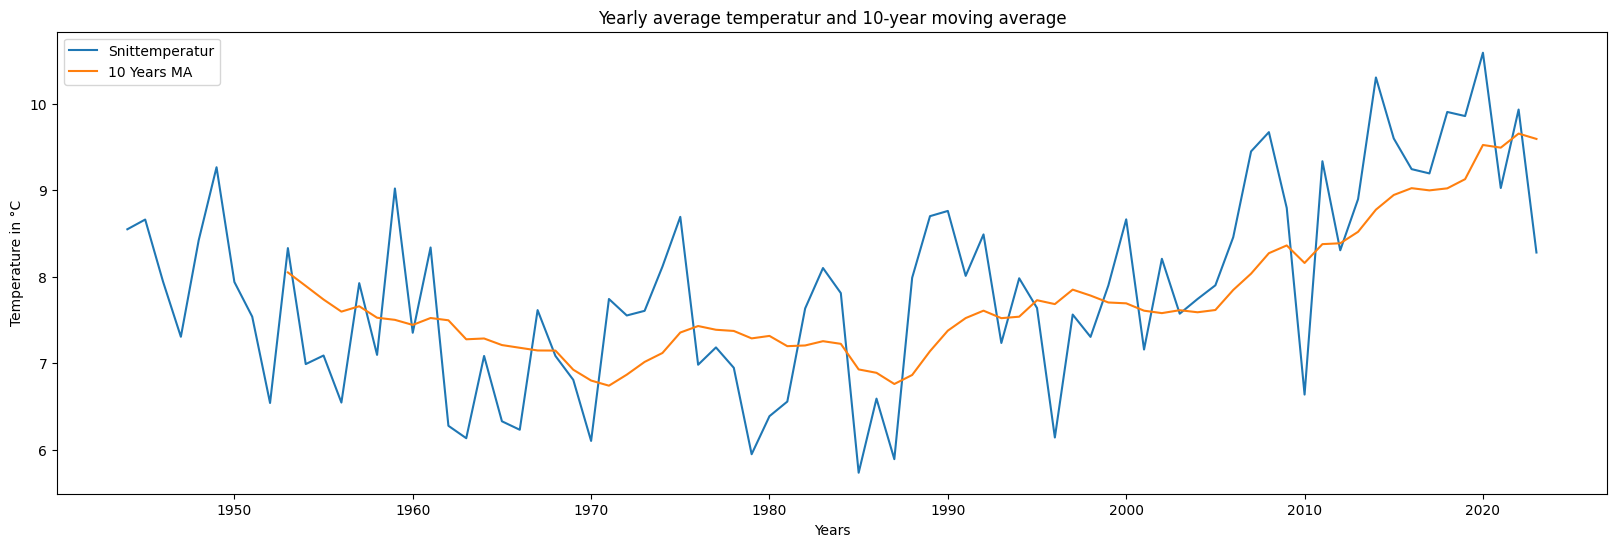

In [77]:
year_avg[['Snittemperatur', '10 Years MA']].plot(figsize=(20,6))
plt.title('Yearly average temperatur and 10-year moving average')
plt.xlabel('Years')
plt.ylabel('Temperature in °C')
plt.show()

Train dates : 1944-01-01 00:00:00 --- 2017-12-31 00:00:00  (n=27029)
Val dates : 2018-01-01 00:00:00 --- 2022-06-30 00:00:00  (n=1642)
Test dates  : 2022-07-01 00:00:00 --- 2023-07-01 00:00:00  (n=366)


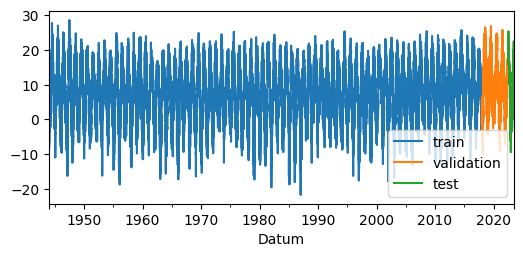

In [92]:
# split training and test data, with cut off at year, 2010

cutoff_date_train = '2018-01-01'
cutoff_date_test = '2022-07-01'
data_train = data[data.index < cutoff_date_train]
data_val = data[(data.index >= cutoff_date_train) & (data.index < cutoff_date_test)]
data_test = data[data.index >= cutoff_date_test]


print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Val dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['Snittemperatur'].plot(ax=ax, label='train')
data_val['Snittemperatur'].plot(ax=ax, label = 'validation')
data_test['Snittemperatur'].plot(ax=ax, label='test')
ax.legend()
plt.show()


In [81]:

data_train['Year'] = pd.to_datetime(data_train['Year'])
data_test['Year'] = pd.to_datetime(data_test['Year'])

data_train['Month'] = pd.to_datetime(data_train['Month'])
data_test['Month'] = pd.to_datetime(data_test['Month'])
data_train.dtypes




Snittemperatur           float64
Year              datetime64[ns]
Month             datetime64[ns]
dtype: object

In [82]:
data_train

,Snittemperatur,Year,Month
Datum,,,
1944-01-01,3.200000,1970-01-01 00:00:00.000001944,1970-01-01 00:00:00.000000001
1944-01-02,3.600000,1970-01-01 00:00:00.000001944,1970-01-01 00:00:00.000000001
1944-01-03,2.800000,1970-01-01 00:00:00.000001944,1970-01-01 00:00:00.000000001
1944-01-04,-4.466667,1970-01-01 00:00:00.000001944,1970-01-01 00:00:00.000000001
1944-01-05,-1.400000,1970-01-01 00:00:00.000001944,1970-01-01 00:00:00.000000001
...,...,...,...
2009-12-27,1.510000,1970-01-01 00:00:00.000002009,1970-01-01 00:00:00.000000012
2009-12-28,-0.700000,1970-01-01 00:00:00.000002009,1970-01-01 00:00:00.000000012
2009-12-29,-2.970000,1970-01-01 00:00:00.000002009,1970-01-01 00:00:00.000000012


validation set? 

In [85]:
# check stationarity- if p-value is lower than 5%, the series is stationary and you can create model 
def check_stationarity(y, lags_plots=48, figsize=(22,8)):
    "Use Series as parameter"
    
    # Creating plots of the DF
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize)
    ax1.set_title('Save Temperature Variation')
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2);
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3);
    sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)
    ax4.set_title('Distribution Chart')

    plt.tight_layout()
    
    print('Results of Dickey-Fuller Test:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Critical Value (%s)"%key] = value.round(4)
        
    print(adftest)
    
    if adftest[0].round(2) < adftest[5].round(2):
        print('\nThe Test Statistics is lower than the Critical Value of 5%.\nThe serie seems to be stationary')
    else:
        print("\nThe Test Statistics is higher than the Critical Value of 5%.\nThe serie isn't stationary")

Results of Dickey-Fuller Test:
Test Statistic                   -12.5183
p-value                            0.0000
Lags Used                         48.0000
Number of Observations Used    24058.0000
Critical Value (1%)               -3.4306
Critical Value (5%)               -2.8617
Critical Value (10%)              -2.5668
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The serie seems to be stationary


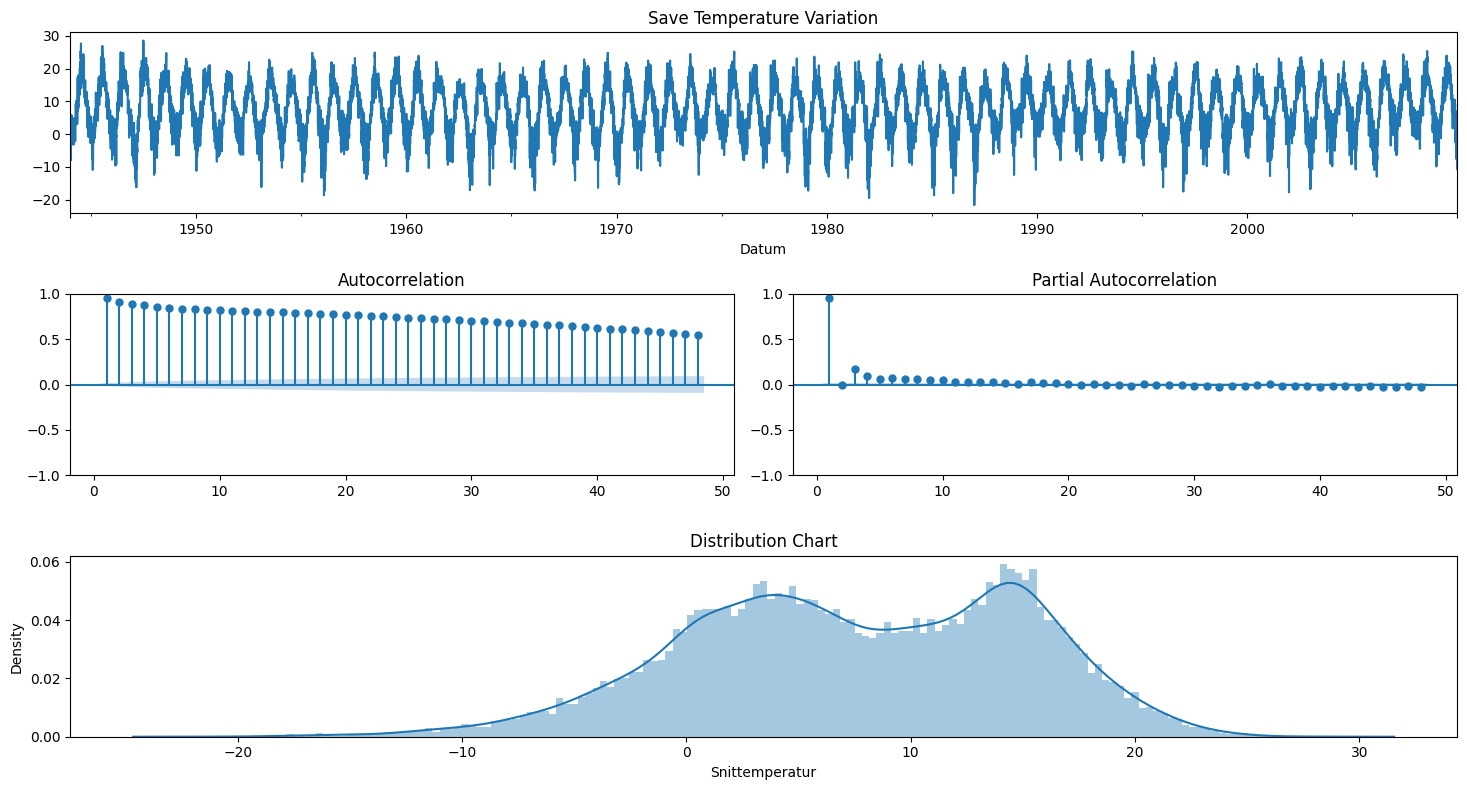

In [86]:
check_stationarity(data_train['Snittemperatur'])


trying with monthly data instead

In [95]:
df_2 = data.resample('M').mean()
train_m = data_train.resample('M').mean()
val_m = data_val.resample('M').mean()
test_m = data_test.resample('M').mean()

In [96]:
train_m

,Snittemperatur,Year,Month
Datum,,,
1944-01-31,2.025806,1944.0,1.0
1944-02-29,0.180460,1944.0,2.0
1944-03-31,0.958065,1944.0,3.0
1944-04-30,6.081111,1944.0,4.0
1944-05-31,10.736559,1944.0,5.0
...,...,...,...
2017-08-31,16.857742,2017.0,8.0
2017-09-30,13.809333,2017.0,9.0
2017-10-31,10.086129,2017.0,10.0


Results of Dickey-Fuller Test:
Test Statistic                  -4.8356
p-value                          0.0000
Lags Used                       14.0000
Number of Observations Used    873.0000
Critical Value (1%)             -3.4379
Critical Value (5%)             -2.8649
Critical Value (10%)            -2.5685
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The serie seems to be stationary


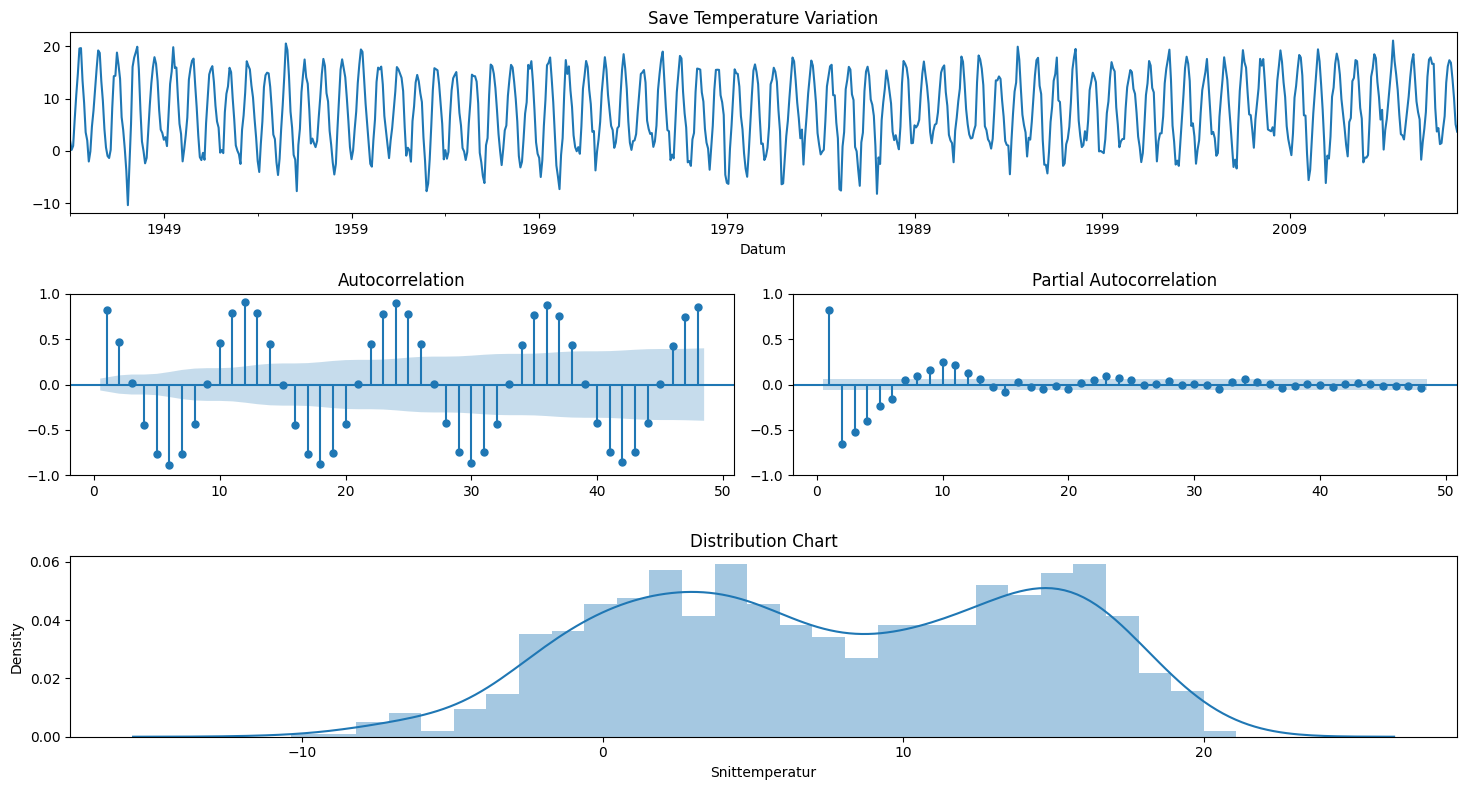

In [101]:
check_stationarity(train_m['Snittemperatur'])

The monthly autocorrelation plot is a visual representation of seasons. It works by showing how this month's temperature is correlated with the following months temperature. We see that there is a diminishing positive autocorrelation up to 3 months after a month. ONce we hit 3, the autocorrelation becomes negative. Showing how we have started to hit a new season where the temperature is very much different than the current one. 6 months after the current month, the temperature is strongly negatively correlated to the current month. Showing that we have entered into an oppositve type of season. 

In [102]:
def walk_forward(training_set, validation_set, params):
    '''
    Params: it's a tuple where you put together the following SARIMA parameters: ((pdq), (PDQS), trend)
    '''
    history = [x for x in training_set.values]
    prediction = list()
    
    # Using the SARIMA parameters and fitting the data
    pdq, PDQS, trend = params

    #Forecasting one period ahead in the validation set
    for week in range(len(validation_set)):
        model = sm.tsa.statespace.SARIMAX(history, order=pdq, seasonal_order=PDQS, trend=trend)
        result = model.fit(disp=False)
        yhat = result.predict(start=len(history), end=len(history))
        prediction.append(yhat[0])
        history.append(validation_set[week])
        
    return prediction

In [103]:
# make a prediction and put it next to the validation 
val_m['Pred'] = walk_forward(train_m['Snittemperatur'], val_m['Snittemperatur'], ((3,0,0),(0,1,1,12),'c'))

In [104]:
baseline = val_m['Snittemperatur'].shift()
baseline.dropna(inplace=True)

def measure_rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true,y_pred))

# Using the function with the baseline values
rmse_base = measure_rmse(val_m.iloc[1:,0],baseline)
print(f'The RMSE of the baseline that we will try to diminish is {round(rmse_base,4)} celsius degrees')

The RMSE of the baseline that we will try to diminish is 4.0443 celsius degrees


In [106]:
rmse_pred = measure_rmse(val_m['Snittemperatur'], val_m['Pred'])

print(f'The RMSE of the SARIMA model  was {round(rmse_pred, 4)} °C')
print(f'Its a decrease of {round((rmse_pred/rmse_base-1)*100,2)}% in the RMSE')

The RMSE of the SARIMA model  was 1.9768 °C
Its a decrease of -51.12% in the RMSE


In [107]:
val_m['Error'] = val_m['Snittemperatur']- val_m['Pred']

In [108]:
val_m

,Snittemperatur,Year,Month,Pred,Error
Datum,,,,,
2018-01-31,2.174839,2018.0,1.0,0.819510,1.355328
2018-02-28,-1.474286,2018.0,2.0,1.012975,-2.487261
2018-03-31,-0.345806,2018.0,3.0,2.170788,-2.516594
2018-04-30,8.441667,2018.0,4.0,5.816860,2.624807
2018-05-31,17.559355,2018.0,5.0,12.445359,5.113996
2018-06-30,18.335000,2018.0,6.0,17.581918,0.753082
2018-07-31,21.365484,2018.0,7.0,19.138762,2.226722
2018-08-31,18.216452,2018.0,8.0,18.832089,-0.615637
2018-09-30,14.771000,2018.0,9.0,14.239578,0.531422


In [109]:
def plot_error(data, figsize=(20,8)): 
    plt.figure(figsize=figsize)
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax2 = plt.subplot2grid((2,2), (0,1))
    ax3 = plt.subplot2grid((2,2), (1,0))
    ax4 = plt.subplot2grid((2,2), (1,1))

    #Plot the current and predicted values 
    ax1.plot(data.iloc[:,0:2])
    ax1.legend(['Actual', 'Pred'])
    ax1.set_title('Actual vs Predicted Monthly Temps')

    #
    ax2.scatter(data.iloc[:,1], data.iloc[:,2])
    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Errors')
    ax2.set_title('Errors versus Predicted Values')

    ## QQ Plot of the residual
    sm.graphics.qqplot(data.iloc[:,2], line='r', ax=ax3)

    # Autocorrelation plot of the residual
    plot_acf(data.iloc[:,2], lags=(len(data.iloc[:,2])-1),zero=False, ax=ax4)
    plt.tight_layout()
    plt.show()
    

In [110]:
val_m.drop(['Month','Year'], axis=1, inplace=True)
val_m.head()

,Snittemperatur,Pred,Error
Datum,,,
2018-01-31,2.174839,0.819510,1.355328
2018-02-28,-1.474286,1.012975,-2.487261
2018-03-31,-0.345806,2.170788,-2.516594
2018-04-30,8.441667,5.816860,2.624807
2018-05-31,17.559355,12.445359,5.113996


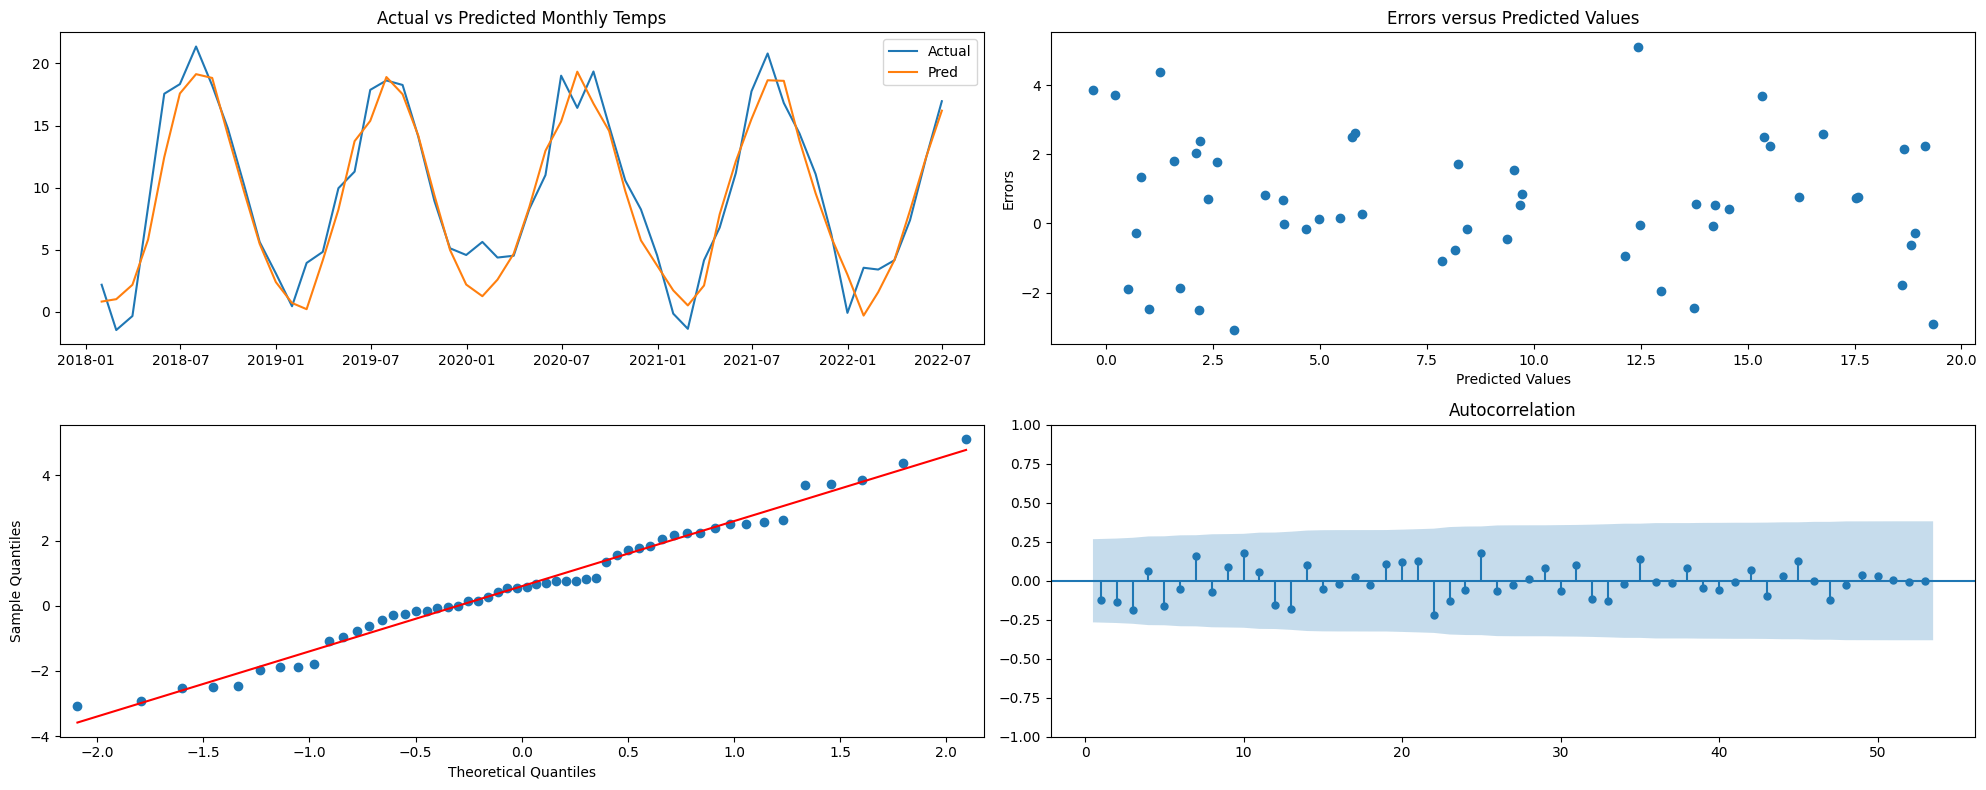

In [111]:
plot_error(val_m)

In [113]:
future = pd.concat([train_m['Snittemperatur'], val_m['Snittemperatur']])
future

Datum
1944-01-31     2.025806
1944-02-29     0.180460
1944-03-31     0.958065
1944-04-30     6.081111
1944-05-31    10.736559
                ...    
2022-02-28     3.399286
2022-03-31     4.146129
2022-04-30     7.375333
2022-05-31    12.430000
2022-06-30    16.959333
Freq: M, Name: Snittemperatur, Length: 942, dtype: float64

In [114]:
model = sm.tsa.statespace.SARIMAX(future, order = (3,0,0), seasonal_order = (0,1,1,12), trend='c')
result = model.fit(disp=False)

Make predictions. to the length of the size of the test data

In [132]:
test_m['Pred'] = result.predict(start = (len(future)), end = (len(future) + 12))

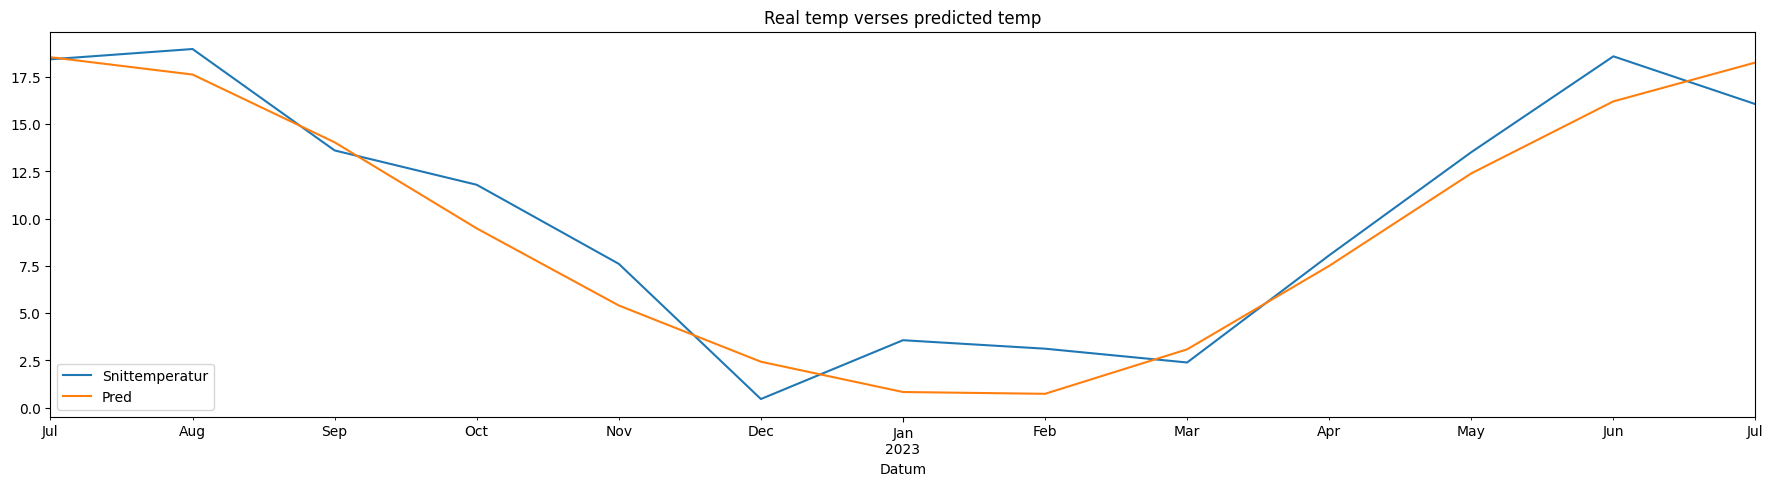

In [120]:
test_m[['Snittemperatur', 'Pred']].plot(figsize=(22,5))
plt.title('Real temp verses predicted temp')
plt.show()

In [119]:
test_baseline = test_m['Snittemperatur'].shift()

test_baseline[0] = test_m['Snittemperatur'][0]

rmse_test_base = measure_rmse(test_m['Snittemperatur'],test_baseline)
rmse_test_extrap = measure_rmse(test_m['Snittemperatur'], test_m['Pred'])

print(f'The baseline RMSE for the test baseline was {round(rmse_test_base,2)} °C ')
print(f'The baseline RMSE for the test extrapolation was {round(rmse_test_extrap,2)} °C')
print(f'That is an improvement of {-round((rmse_test_extrap/rmse_test_base-1)*100,2)}%')

The baseline RMSE for the test baseline was 3.98 °C 
The baseline RMSE for the test extrapolation was 1.8 °C
That is an improvement of 54.86%


Make predictions, out into the future 

In [177]:
lt_pred = result.predict(start = (len(future))+13, end = (len(future) + 240))
lt_pred = pd.DataFrame({'Snittemperatur': lt_pred})

In [178]:
test_m

,Snittemperatur,Year,Month,Pred
Datum,,,,
2022-07-31,18.432581,2022.0,7.0,18.542999
2022-08-31,18.976774,2022.0,8.0,17.626115
2022-09-30,13.610333,2022.0,9.0,14.040271
2022-10-31,11.792581,2022.0,10.0,9.485126
2022-11-30,7.607667,2022.0,11.0,5.405561
2022-12-31,0.454839,2022.0,12.0,2.428614
2023-01-31,3.567097,2023.0,1.0,0.825795
2023-02-28,3.118214,2023.0,2.0,0.730937
2023-03-31,2.388065,2023.0,3.0,3.083588


In [179]:
lt_pred

,Snittemperatur
2023-08-31,17.493954
2023-09-30,13.962696
2023-10-31,9.451331
2023-11-30,5.396288
2023-12-31,2.432703
...,...
2042-03-31,3.503128
2042-04-30,7.923099
2042-05-31,12.817753
2042-06-30,16.628776


New plot with real temp and long term predictions 

In [153]:
# drop extra stuff from test_m
test = test_m.drop(columns=['Year','Month','Pred'])
test

,Snittemperatur
Datum,
2022-07-31,18.432581
2022-08-31,18.976774
2022-09-30,13.610333
2022-10-31,11.792581
2022-11-30,7.607667
2022-12-31,0.454839
2023-01-31,3.567097
2023-02-28,3.118214
2023-03-31,2.388065


In [156]:
train_val = pd.DataFrame({'Snittemperatur': future})

,Snittemperatur
Datum,
1944-01-31,2.025806
1944-02-29,0.180460
1944-03-31,0.958065
1944-04-30,6.081111
1944-05-31,10.736559
...,...
2022-02-28,3.399286
2022-03-31,4.146129
2022-04-30,7.375333


In [182]:
lt_future = pd.concat([train_val['Snittemperatur'], test['Snittemperatur'], lt_pred['Snittemperatur']])
lt_future = pd.DataFrame({'Snittemperatur': lt_future})
lt_future

,Snittemperatur
1990-01-31,3.743356
1990-02-28,4.991505
1990-03-31,5.208602
1990-04-30,7.364330
1990-05-31,11.379557
...,...
2042-03-31,3.503128
2042-04-30,7.923099
2042-05-31,12.817753
2042-06-30,16.628776


### plot the predictions 

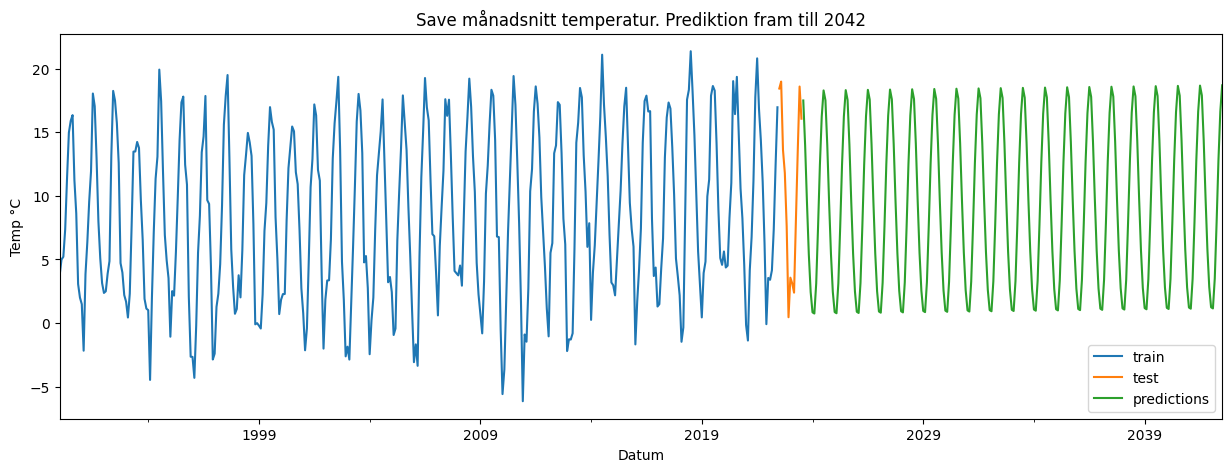

In [183]:
fig, ax = plt.subplots(figsize=(15, 5))


# Filter data from 1990 onwards
train_val = train_val[train_val.index >= '1990-01-01']


train_val['Snittemperatur'].plot(ax=ax, label='train')
test['Snittemperatur'].plot(ax=ax, label = 'test')
lt_pred['Snittemperatur'].plot(ax=ax, label='predictions')
ax.set_xlabel('Datum')
ax.set_ylabel('Temp °C')
ax.set_title('Save månadsnitt temperatur. Prediktion fram till 2042')
ax.legend()
plt.show()